In [25]:
import os
os.environ['KAGGLE_USERNAME'] = 'ibrahimelsayed25'
os.environ['KAGGLE_KEY'] = "01df320c0ba010cb1c6ff4314c310a57"

In [26]:
! kaggle competitions download uw-madison-gi-tract-image-segmentation

uw-madison-gi-tract-image-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/uw-madison-gi-tract-image-segmentation.zip

In [ ]:
!pip install segmentation_models

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import cv2
import gc
from tqdm import tqdm
from  datetime import datetime
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold, KFold, StratifiedKFold

from tensorflow import keras
import tensorflow as tf
import keras
from keras.models import load_model, save_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.models import Model
from keras.layers import Input
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

from dataLoader import *
from  utils import *

from rle import *
from datagen import *
from dice import *

Segmentation Models: using `keras` framework.


In [2]:
BATCH_SIZE = 16
EPOCH = 10
n_splits = 5
fold_selected = 2

In [3]:
glob('train/*/*/*/*.png')

['train/case115/case115_day0/scans/slice_0029_266_266_1.50_1.50.png',
 'train/case115/case115_day0/scans/slice_0006_266_266_1.50_1.50.png',
 'train/case115/case115_day0/scans/slice_0048_266_266_1.50_1.50.png',
 'train/case115/case115_day0/scans/slice_0007_266_266_1.50_1.50.png',
 'train/case115/case115_day0/scans/slice_0121_266_266_1.50_1.50.png',
 'train/case115/case115_day0/scans/slice_0093_266_266_1.50_1.50.png',
 'train/case115/case115_day0/scans/slice_0009_266_266_1.50_1.50.png',
 'train/case115/case115_day0/scans/slice_0127_266_266_1.50_1.50.png',
 'train/case115/case115_day0/scans/slice_0128_266_266_1.50_1.50.png',
 'train/case115/case115_day0/scans/slice_0064_266_266_1.50_1.50.png',
 'train/case115/case115_day0/scans/slice_0099_266_266_1.50_1.50.png',
 'train/case115/case115_day0/scans/slice_0134_266_266_1.50_1.50.png',
 'train/case115/case115_day0/scans/slice_0140_266_266_1.50_1.50.png',
 'train/case115/case115_day0/scans/slice_0058_266_266_1.50_1.50.png',
 'train/case115/case

## Load Data

In [4]:
df_train = pd.read_csv('train.csv')
df_train

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


In [5]:
df_train['class'].value_counts()

large_bowel    38496
small_bowel    38496
stomach        38496
Name: class, dtype: int64

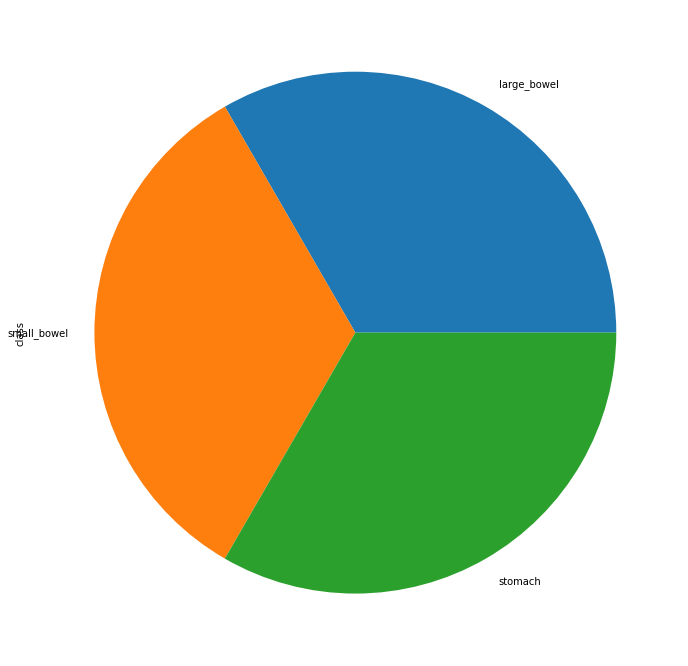

In [6]:
plt.figure(figsize=(28,12))
df_train['class'].value_counts(normalize=True).plot.pie()

In [7]:
test_df = pd.read_csv('sample_submission.csv')
test_df.head()

,id,class,predicted


In [8]:
test_df = pd.read_csv('train.csv').iloc[:300,:]
test_df['segmentation']=''
test_df = test_df.rename(columns={'segmentation':'prediction'})

submission = test_df.copy()
test_df.head()

,id,class,prediction
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


In [9]:
total_train_df = prepare_data(df_train)
total_train_df

,id,class,segmentation,case,day,full_path,case_and_day,img_file_name,slice,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,train/case123/case123_day20/scans/slice_0001_2...,case123_day20,slice_0001_266_266_1.50_1.50.png,slice_0001,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,train/case123/case123_day20/scans/slice_0001_2...,case123_day20,slice_0001_266_266_1.50_1.50.png,slice_0001,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,train/case123/case123_day20/scans/slice_0001_2...,case123_day20,slice_0001_266_266_1.50_1.50.png,slice_0001,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,train/case123/case123_day20/scans/slice_0002_2...,case123_day20,slice_0002_266_266_1.50_1.50.png,slice_0002,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,train/case123/case123_day20/scans/slice_0002_2...,case123_day20,slice_0002_266_266_1.50_1.50.png,slice_0002,266,266
...,...,...,...,...,...,...,...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN,30,0,train/case30/case30_day0/scans/slice_0143_266_...,case30_day0,slice_0143_266_266_1.50_1.50.png,slice_0143,266,266
115484,case30_day0_slice_0143,stomach,NaN,30,0,train/case30/case30_day0/scans/slice_0143_266_...,case30_day0,slice_0143_266_266_1.50_1.50.png,slice_0143,266,266
115485,case30_day0_slice_0144,large_bowel,NaN,30,0,train/case30/case30_day0/scans/slice_0144_266_...,case30_day0,slice_0144_266_266_1.50_1.50.png,slice_0144,266,266
115486,case30_day0_slice_0144,small_bowel,NaN,30,0,train/case30/case30_day0/scans/slice_0144_266_...,case30_day0,slice_0144_266_266_1.50_1.50.png,slice_0144,266,266


In [10]:
test_df = prepare_data(test_df)
test_df.head()

,id,class,prediction,case,day,full_path,case_and_day,img_file_name,slice,height,width
0,case123_day20_slice_0001,large_bowel,,123,20,train/case123/case123_day20/scans/slice_0001_2...,case123_day20,slice_0001_266_266_1.50_1.50.png,slice_0001,266,266
1,case123_day20_slice_0001,small_bowel,,123,20,train/case123/case123_day20/scans/slice_0001_2...,case123_day20,slice_0001_266_266_1.50_1.50.png,slice_0001,266,266
2,case123_day20_slice_0001,stomach,,123,20,train/case123/case123_day20/scans/slice_0001_2...,case123_day20,slice_0001_266_266_1.50_1.50.png,slice_0001,266,266
3,case123_day20_slice_0002,large_bowel,,123,20,train/case123/case123_day20/scans/slice_0002_2...,case123_day20,slice_0002_266_266_1.50_1.50.png,slice_0002,266,266
4,case123_day20_slice_0002,small_bowel,,123,20,train/case123/case123_day20/scans/slice_0002_2...,case123_day20,slice_0002_266_266_1.50_1.50.png,slice_0002,266,266


In [11]:
train_df_restructured = rearrange_dataframe_for_3_segmentation_classes(total_train_df)
train_df_restructured.head()

,id,large_bowel,small_bowel,stomach,full_path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,train/case123/case123_day20/scans/slice_0001_2...,123,20,slice_0001,266,266,0
1,case123_day20_slice_0002,,,,train/case123/case123_day20/scans/slice_0002_2...,123,20,slice_0002,266,266,0
2,case123_day20_slice_0003,,,,train/case123/case123_day20/scans/slice_0003_2...,123,20,slice_0003,266,266,0
3,case123_day20_slice_0004,,,,train/case123/case123_day20/scans/slice_0004_2...,123,20,slice_0004,266,266,0
4,case123_day20_slice_0005,,,,train/case123/case123_day20/scans/slice_0005_2...,123,20,slice_0005,266,266,0


In [12]:
## Remove mislabeled training data
train_df_restructured = train_df_restructured[(df_train['case'] != 7) | (df_train['day'] != 0) ].reset_index(drop=True)

train_df_restructured = train_df_restructured[(df_train['case'] != 81) | (df_train['day'] != 30)].reset_index(drop=True)

train_df_restructured = train_df_restructured[(df_train['case'] != 138) | (df_train['day'] != 00)].reset_index(drop=True)



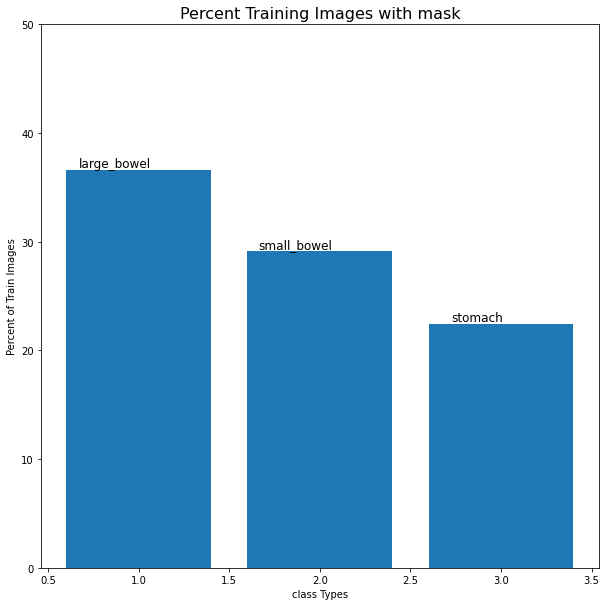

In [13]:
plot_classes_density(train_df_restructured)

## Cross validation

In [14]:
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True)

for fold, (_, val_idx) in enumerate(skf.split(X=train_df_restructured , y = train_df_restructured['count'], groups = train_df_restructured['case']),1):
  train_df_restructured.loc[val_idx, "fold"] = fold

train_df_restructured['fold'] = train_df_restructured["fold"].astype(np.uint8)

train_ids = train_df_restructured[train_df_restructured["fold"] != fold_selected].index
valid_ids = train_df_restructured[train_df_restructured["fold"] == fold_selected].index

X_train = train_df_restructured[train_df_restructured.index.isin(train_ids)]
X_valid = train_df_restructured[train_df_restructured.index.isin(valid_ids)]



In [15]:
train_generator = DataGenerator(X_train,batch_size=BATCH_SIZE,shuffle=True)
val_generator = DataGenerator(X_valid,batch_size=BATCH_SIZE)

## Model

In [16]:
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [17]:
from keras.engine import input_layer
model = Unet('inceptionresnetv2', input_shape = (128,128,3), classes = 3, activation = 'sigmoid',encoder_weights='imagenet')
model.compile(optimizer='adam', loss = bce_dice_loss, metrics=[dice_coef, iou_coef])

In [ ]:
checkpoint = ModelCheckpoint('UNET_model', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(patience=5, min_delta=0.0001, restore_best_weights=True)

history = model.fit(train_generator, validation_data= val_generator, callbacks = [checkpoint, early_stopping], use_multiprocessing=False, workers=4, epochs=EPOCH )


In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.plot(range(history.epoch[-1] + 1), history.history['loss'], label='Train Loss' )
plt.plot(range(history.epoch[-1] + 1), history.history['val_loss'], label='Validation Loss' )
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(history.epoch[-1] + 1), history.history['dice_coef'], label='Train Dice Coeff' )
plt.plot(range(history.epoch[-1] + 1), history.history['val_dice_coef'], label='Validation Dice Coef' )
plt.title('Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(history.epoch[-1] + 1), history.history['iou_coef'], label='Train IoU Coeff' )
plt.plot(range(history.epoch[-1] + 1), history.history['val_iou_coef'], label='Validation IoU Coef' )
plt.title('IoU Loss')
plt.xlabel('Epochs')
plt.ylabel('IoU Coef')
plt.legend()
plt.show()